In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
import os
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import json

from ml_genn import Network, Population, Connection
from ml_genn.callbacks import SpikeRecorder, VarRecorder
from ml_genn.compilers import InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput
from ml_genn.synapses import Exponential

from ml_genn.utils.data import calc_latest_spike_time
from ml_genn.compilers.event_prop_compiler import default_params

from ml_genn.utils.data import (calc_latest_spike_time, calc_max_spikes,
                                preprocess_tonic_spikes)

from rawHD_dataset_loader_padded_spikes import rawHD_Loader

In [3]:
# sample ID used for visual
sample_id = 0

In [4]:
with open("rawHD_params.json", "r") as f: 
    params = json.load(f)
    
params["num_samples"] = None
params["NUM_OUTPUT"] = 12
params["output_dir"] = "rawHD_speaker_training_1_inference"
params["NUM_EPOCH"] = 20
params["BATCH_SIZE"] = 32
params["weights_dir"] = "rawHD_pretrained_weights_recurrent_speakers"

In [5]:
x_train, y_train, z_train, x_test, y_test, z_test, x_validation, y_validation, z_validation = rawHD_Loader(dir = os.getcwd() + params["dataset_directory"],
                                                                                                           num_samples=params["num_samples"],
                                                                                                           shuffle = True,
                                                                                                           shuffle_seed = 0,
                                                                                                           process_padded_spikes = False)


In [6]:
print(f"training speakers: {np.unique(z_train)}")
print(f"testing speakers : {np.unique(z_test)}")

training speakers: [ 0  1  2  3  6  7  8  9 10 11]
testing speakers : [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [7]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

#x_test = np.load("spiking-google-speech-commands/testing_x_spikes.npy", allow_pickle=True)
#y_test = np.load("spiking-google-speech-commands/testing_y_spikes.npy", allow_pickle=True)

# Preprocess
x_train_spikes = []
for i in range(len(x_train)):
    events = x_train[i]
    x_train_spikes.append(preprocess_tonic_spikes(events, 
                                                  x_train[0].dtype.names,
                                                  (params["NUM_INPUT"], 1, 1),
                                                  time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_train_spikes)
latest_spike_time = 2000 #calc_latest_spike_time(x_train_spikes) #TODO: Fix
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
Max spikes 2386, latest spike time 2000


In [8]:
# Kaggle dataset directory
dataset = 'https://www.kaggle.com/datasets/thomasshoesmith/spiking-google-speech-commands/data'

# Using opendatasets to download SGSC dataset
od.download(dataset)

#x_test = np.load("spiking-google-speech-commands/testing_x_spikes.npy", allow_pickle=True)
#y_test = np.load("spiking-google-speech-commands/testing_y_spikes.npy", allow_pickle=True)

# Preprocess
x_test_spikes = []
for i in range(len(x_test)):
    events = x_test[i]
    x_test_spikes.append(preprocess_tonic_spikes(events, 
                                                 x_test[0].dtype.names,
                                                 (params["NUM_INPUT"], 1, 1),
                                                 time_scale = 1))

# Determine max spikes and latest spike time
max_spikes = calc_max_spikes(x_test_spikes)
latest_spike_time = 2000 #calc_latest_spike_time(x_train_spikes) #TODO: Fix
print(f"Max spikes {max_spikes}, latest spike time {latest_spike_time}")

Skipping, found downloaded files in "./spiking-google-speech-commands" (use force=True to force download)
Max spikes 2190, latest spike time 2000


In [9]:
# loading pretrained weights
w_i2h = np.load(f"{params['weights_dir']}/rawHD_Pop0_Pop1-g.npy")
w_i2h = w_i2h.reshape((params["NUM_INPUT"], 
                       params["NUM_HIDDEN"]))

if params["recurrent"]:
    w_h2h = np.load(f"{params['weights_dir']}/rawHD_Pop1_Pop1-g.npy")
    w_h2h = w_h2h.reshape((params["NUM_HIDDEN"],
                           params["NUM_HIDDEN"]))

w_h2o = np.load(f"{params['weights_dir']}/rawHD_Pop1_Pop2-g.npy")
w_h2o = w_h2o.reshape((params["NUM_HIDDEN"], 
                       params["NUM_OUTPUT"]))

In [10]:
# change directory for output code of (ML_)GeNN
try:
    os.makedirs("output/" + params["output_dir"] + "_inference_run")
except:
    pass

os.chdir("output/" + params["output_dir"] + "_inference_run")

In [11]:
network = Network(default_params)

with network:
    # Populations
    input = Population(SpikeInput(max_spikes = params["BATCH_SIZE"] * max_spikes),
                       params["NUM_INPUT"],
                       record_spikes=True)
    
    hidden = Population(LeakyIntegrateFire(v_thresh=1.0, 
                                    tau_mem=20.0),
                params.get("NUM_HIDDEN"), 
                record_spikes=True)
    
    output = Population(LeakyIntegrate(tau_mem=20.0, 
                                readout="avg_var_exp_weight"),
                params.get("NUM_OUTPUT"), 
                record_spikes=True)

    Connection(input, hidden, Dense(weight = w_i2h),
                Exponential(5.0))
    
    if params.get("recurrent"):
        Connection(hidden, hidden, Dense(weight = w_h2h),
                Exponential(5.0))
    
    Connection(hidden, output, Dense(w_h2o),
                Exponential(5.0))

compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                            reset_in_syn_between_batches=True,
                            #quantise_num_weight_bits=8,
                            #quantise_weight_percentile=99,
                            batch_size = params.get("BATCH_SIZE"))

compiled_net = compiler.compile(network)


with compiled_net:

    callbacks = ["batch_progress_bar",
                 SpikeRecorder(input, 
                               key = "input_spikes",
                               example_filter = sample_id),
                 SpikeRecorder(hidden,
                               key = "hidden_spikes",
                               example_filter = sample_id),
                VarRecorder(hidden, 
                             var = "v",
                             key = "hidden_voltages",
                             example_filter = sample_id),
                 VarRecorder(output, 
                             var = "v",
                             key = "output_voltages",
                             example_filter = sample_id)]
    
    
    #metrics, cb_data = compiled_net.evaluate({input: x_train_spikes}, {output: z_train}, callbacks = callbacks)
    #metrics, cb_data = compiled_net.predict({input: x_train_spikes}, output, callbacks = callbacks)
    
    metrics, cb_data = compiled_net.evaluate({input: x_test_spikes}, {output: z_test}, callbacks = callbacks)
    metrics, cb_data = compiled_net.predict({input: x_test_spikes}, output, callbacks = callbacks)

    #compiled_net.save(("quant8",), serialiser)


    #print(f"Accuracy = {100 * metrics[output].result}%")

/its/home/ts468/PhD/ve/genn_5_1_0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_speaker_training_1_inference_inference_run/InferenceCompiler_CODE'
make: Nothing to be done for 'all'.
make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/output/rawHD_speaker_training_1_inference_inference_run/InferenceCompiler_CODE'


100%|██████████| 71/71 [00:00<00:00, 77.24it/s]


In [12]:
# use to print predicted and ground truth output of GeNN Inference run
if True:
    os.chdir("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project")

    my_list = []
    for i in range(len(z_train)):
        my_list.append(f"Pred: {np.argmax(metrics[output][i])}, True:{z_train[i]}")

    file_path = "rawHD_genn_speaker_inference_predicted.txt"
    print(my_list)

    with open(file_path, 'w') as file:
        # Join the list elements into a single string with a newline character
        data_to_write = '\n'.join(my_list)
        
        # Write the data to the file
        file.write(data_to_write)

IndexError: index 2264 is out of bounds for axis 0 with size 2264

In [ ]:
os.chdir("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project")

In [ ]:
# Input spike activity
plt.scatter(cb_data["input_spikes"][0][0], cb_data["input_spikes"][1][0],
            s = 1)

plt.title('Input Spikes (with raw input for comparison) from lava')
plt.ylim(0, params["NUM_INPUT"])
plt.xlim(0, 2000)
plt.show()

In [ ]:
plt.scatter(cb_data["hidden_spikes"][0][0], cb_data["hidden_spikes"][1][0],
            s = 0.5)

plt.ylabel("neurons")
plt.xlabel("timesteps")
plt.title("Hidden layer activity")
plt.ylim(0, params["NUM_HIDDEN"])
plt.xlim(0, 2000)
plt.show()

In [ ]:
plt.figure(figsize=(12, 3), dpi=80)

plt.plot(cb_data["hidden_voltages"][0][:,16])

plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
plt.title("hidden voltage activity")
#plt.xlim(450, 600)

plt.show()

In [ ]:
plt.figure(figsize=(12, 3), dpi=80)

plt.plot(cb_data["hidden_voltages"][0][:,299])

plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
plt.title("hidden voltage activity")
#plt.xlim(450, 600)
#plt.xlim(650, 720)
plt.xlim(300, 400)
#plt.ylim(0, 1 * 1.1)

plt.scatter([cb_data["hidden_spikes"][0][0][i] for i in np.where(cb_data["hidden_spikes"][1][0] == 299)][0],
            len([cb_data["hidden_spikes"][0][0][i] for i in np.where(cb_data["hidden_spikes"][1][0] == 299)][0]) * [1],
            c = "r",
            label = "spikes")

for i in range(1000):
    plt.axvline(i * 10, color = "grey", alpha=0.5, linestyle = "dashed")

plt.axhline(1, color = "red", alpha=0.5, linestyle = "dashed", label = "threshold")

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 3), dpi=80)

plt.plot(cb_data["output_voltages"][0])

plt.ylabel("voltage (v)")
plt.xlabel("timesteps")
plt.title("output voltage activity")
plt.xlim(0, 2000)

plt.show()

In [ ]:
plt.plot(np.sort(w_i2h.flatten()))
plt.title("input to hidden")
plt.show()

In [ ]:
if params["recurrent"]:
    plt.plot(np.sort(w_h2h.flatten()))
    plt.title("hidden to hidden")
    plt.show()

In [ ]:
plt.plot(np.sort(w_h2o.flatten()))
plt.title("hidden to output")
plt.show()

Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(z_train, np.argmax(metrics[output], 1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title('Speaker Confusion Matrix', fontsize=18)
plt.xticks(list(range(10)), np.unique(z_train))
plt.yticks(list(range(10)), np.unique(z_train))
plt.show()

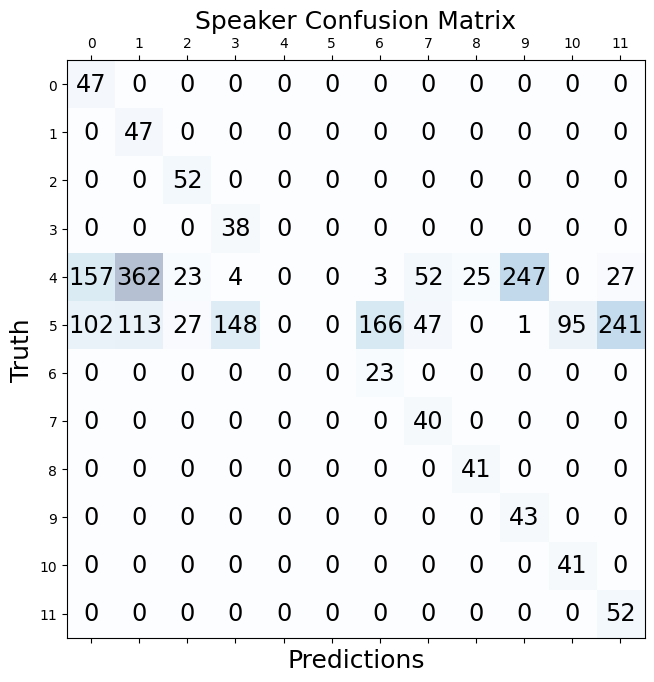

In [20]:
cm = confusion_matrix(z_test, np.argmax(metrics[output], 1))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title('Speaker Confusion Matrix', fontsize=18)
plt.xticks(list(range(12)))
plt.yticks(list(range(12)))
plt.show()